Notebook to train and analyze a Mixture of Experts architecture using label split on the default mnist dataset. Experts are trained with an additional 'unknown' label so that they can also work with other classes than the defined ones. During training and evaluation a decoding approach using a python dictionary is used to decode unknown labels.

In [1]:
import torch
import torchvision
from torch.utils.data import ConcatDataset
import numpy as np
from models.mnist.mnist_net import MnistNet
from models.mnist.gating_network import GatingNetwork
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset
from itertools import combinations
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

In [2]:
transformations_mnist_default = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

In [3]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [4]:
# Preparing mnist datasets for all digits
mnist_dataset = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_train, mnist_valid = train_test_split(mnist_dataset, [0.8, 0.2])
mnist_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

In [5]:
perm = combinations([i for i in range(10)], 2) 
training_sets = []
validation_sets = []
experts = []

for i, labels in enumerate(perm):
    unknown_labels = list(set([i for i in range(10)]) - set(list(labels)))

    known_classes_training = build_subset(mnist_train, labels=labels)
    unknown_classes_training = build_subset(mnist_train, labels=unknown_labels)
    
    shrinking_factor = (len(known_classes_training) / len(unknown_classes_training)) / len(labels)
    unknown_classes_training, _ = train_test_split(unknown_classes_training, [shrinking_factor, 1-shrinking_factor])

    known_classes_validation = build_subset(mnist_valid, labels=labels)
    unknown_classes_validation = build_subset(mnist_valid, labels=unknown_labels)

    shrinking_factor = (len(known_classes_validation) / len(unknown_classes_validation)) / len(labels)
    unknown_classes_validation, _ = train_test_split(unknown_classes_validation, [shrinking_factor, 1-shrinking_factor])

    training_sets.append(ConcatDataset([known_classes_training, unknown_classes_training]))
    validation_sets.append(ConcatDataset([known_classes_validation, unknown_classes_validation]))

    label_str = ''
    for label in labels:
        label_str += str(label)

    expert = MnistNet(classes=list(labels), name='expert_' + label_str, unknown_class=True)
    expert.load_state_dict(torch.load('./trained_models/label_split_combinations_unknown_labels/expert_' + label_str + '_unknown.pth'))
    # expert.fit(
    #     training_data=training_sets[i],
    #     validation_data=validation_sets[i],
    #     num_epochs=5,
    #     batch_size=128,
    #     device=device,
    #     criterion=criterion,
    #     optimizer=optimizer,
    #     learning_rate=0.0005,
    #     save_state_path='./trained_models/label_split_combinations_unknown_labels/expert_' + label_str + '_unknown.pth'
    #     )
    experts.append(expert)

In [6]:
gate = GatingNetwork(classes=[i for i in range(10)], experts=experts)
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.8915, 'acc': 0.9817, 'entropy': 2.7079}

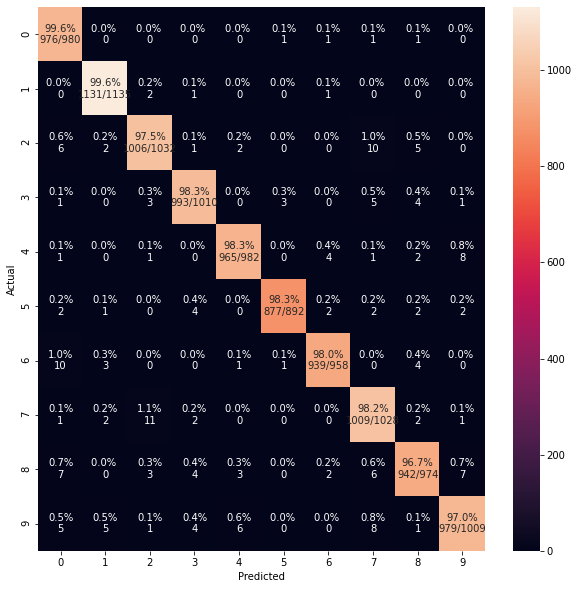

In [7]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [8]:
gate.load_state_dict(torch.load('./trained_models/label_split_combinations_unknown_labels/gate_decoding.pth'))
# gate.fit(
#     training_data=mnist_train, 
#     validation_data=mnist_valid, 
#     num_epochs=20, 
#     batch_size=256, 
#     device=device, 
#     criterion=criterion, 
#     optimizer=optimizer, 
#     learning_rate=0.0001, 
#     save_state_path='./trained_models/label_split_combinations_unknown_labels/gate_decoding.pth'
#     )

<All keys matched successfully>

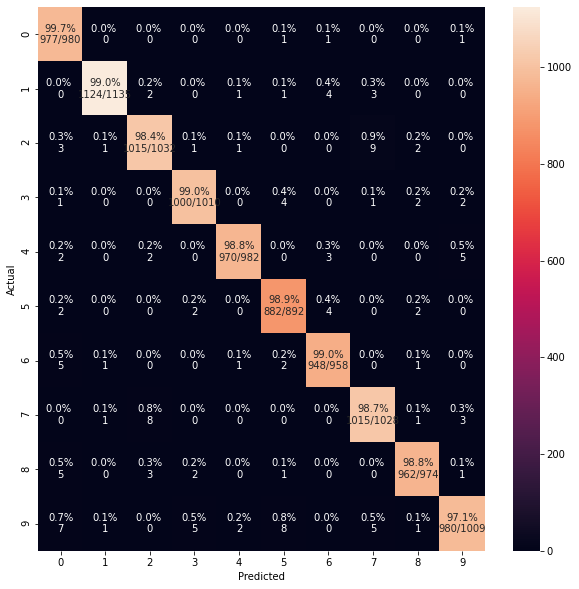

In [9]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [10]:
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.0851, 'acc': 0.9873, 'entropy': 0.2802}

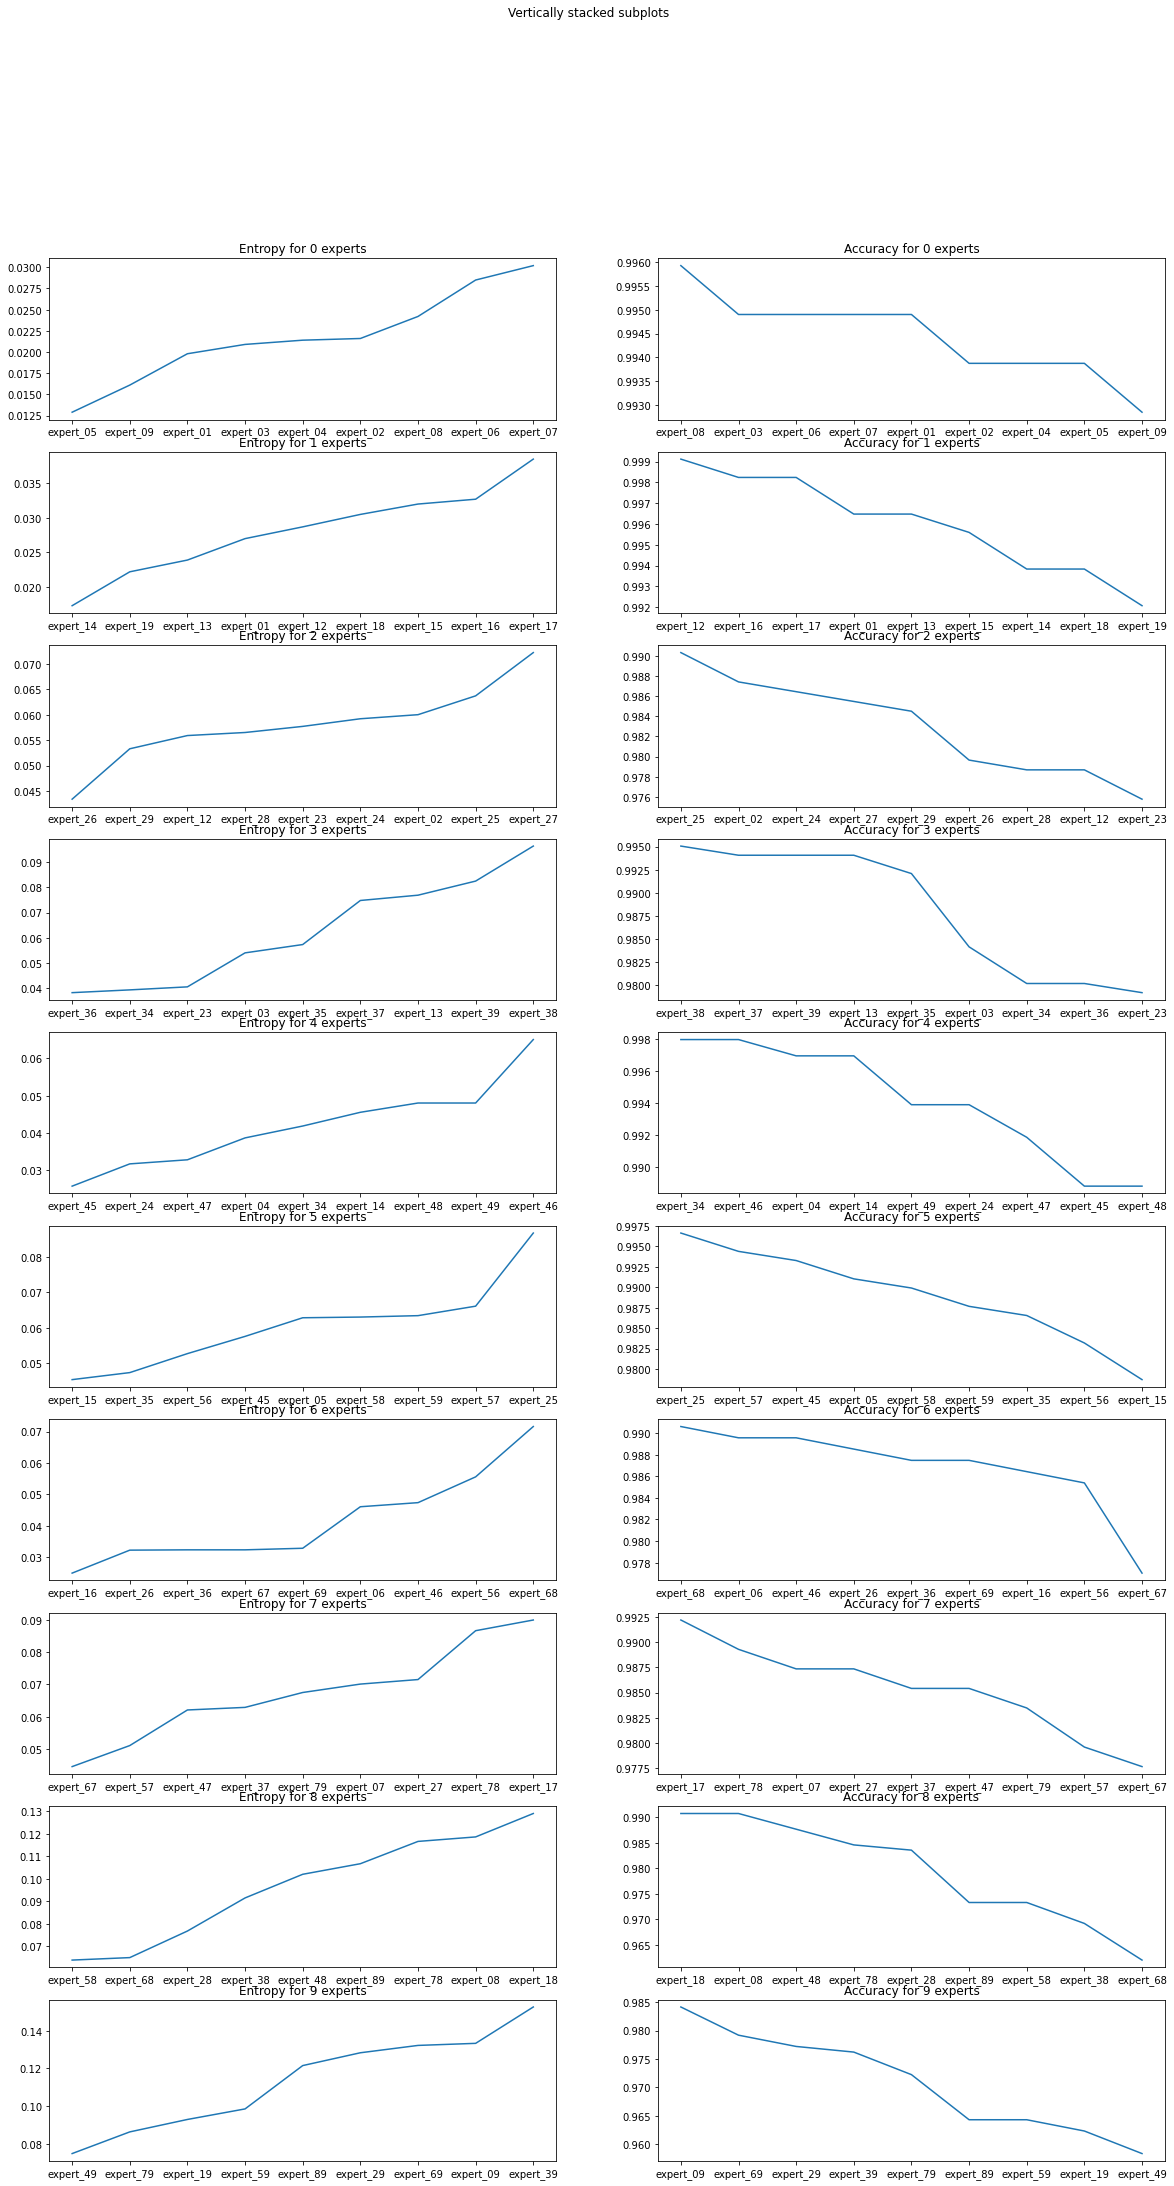

In [11]:
fig, axs = plt.subplots(10, 2, figsize=(20,35))
fig.suptitle('Vertically stacked subplots')

df = pd.DataFrame(columns=['label', 'expert 1', 'weight 1', 'expert 2', 'weight 2', 'expert 3', 'weight 3'])

for i in range(10):
    testset = MNISTDataset('../../data/default_mnist/testing', labels=[i], transform=transformations_mnist_default)
    loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
    weight_sum = torch.zeros((1, len(gate.experts))).to(device)
    with torch.no_grad():
        for _, (images, labels) in enumerate(loader):
            images = images.to(device)
            weight_sum += torch.sum(gate(images)['weights'], dim=0)
        weight_sum = weight_sum / len(testset)
    
    sorted_indices = torch.argsort(weight_sum, dim=1, descending=True)[0].cpu().numpy()
    exp = gate.experts
    exp_results = []
    
    for e in experts:
        if str(i) in e.name:
            result = e.evaluate(
                test_data=testset,
                batch_size=128,
                criterion=criterion,
                device=device
            )
            exp_results.append(result)

    entr = [x['entropy'] for x in sorted(exp_results, key=lambda x: x['entropy'])[:]]
    names = [x['name'] for x in sorted(exp_results, key=lambda x: x['entropy'])[:]]
    axs[i, 0].plot(names, entr)
    axs[i, 0].set_title('Entropy for ' + str(i) + ' experts')

    acc = [x['acc'] for x in sorted(exp_results, key=lambda x: x['acc'], reverse=True)[:]]
    names = [x['name'] for x in sorted(exp_results, key=lambda x: x['acc'])[:]]
    axs[i, 1].plot(names, acc)
    axs[i, 1].set_title('Accuracy for ' + str(i) + ' experts')

    weight_sum = weight_sum[0] 

    result_dict = dict()
    result_dict['label'] = i
    result_dict['expert 1'] = exp[sorted_indices[0]].name
    result_dict['weight 1'] = weight_sum[sorted_indices[0]].item()
    result_dict['expert 2'] = exp[sorted_indices[1]].name
    result_dict['weight 2'] = weight_sum[sorted_indices[1]].item()
    result_dict['expert 3'] = exp[sorted_indices[2]].name
    result_dict['weight 3'] = weight_sum[sorted_indices[2]].item()
    df = df.append(result_dict, ignore_index=True)

In [12]:
df

,label,expert 1,weight 1,expert 2,weight 2,expert 3,weight 3
0,0,expert_03,0.957400,expert_06,0.019521,expert_05,0.017739
1,1,expert_16,0.583107,expert_01,0.401127,expert_27,0.005288
2,2,expert_27,0.604836,expert_23,0.187567,expert_02,0.187564
3,3,expert_35,0.925812,expert_23,0.062064,expert_03,0.004814
4,4,expert_49,0.616691,expert_24,0.375529,expert_26,0.002977
5,5,expert_35,0.963632,expert_15,0.013921,expert_05,0.010892
6,6,expert_26,0.988105,expert_03,0.004081,expert_35,0.001778
7,7,expert_27,0.575921,expert_78,0.417094,expert_49,0.003486
8,8,expert_68,0.887331,expert_58,0.057138,expert_48,0.042099
9,9,expert_19,0.827010,expert_49,0.144431,expert_35,0.017603
